In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

#ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스
class BasicBlock(nn.Module): # 논문에 나오는 하나하나의 residual 블럭 ex. [3X3,64  3X3,64]
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()

    # 3X3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

    # 3X3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)


    # shorcut connection을 통해서 mapping을 수행할 수 있도록 한다. 
    self.shortcut = nn.Sequential() # identity인 경우
    if stride != 1: # stride가 1이 아니라면(입력값과 출력값의 dimension이 다르다는 의미), identity mapping이 아닌 경우
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),# dimension을 맞춰준다.
          nn.BatchNorm2d(planes)
      )

  # residual block
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x) # (핵심) skip connection , x mapping
    out = F.relu(out)
    return out


In [2]:
# ResNet 클래스 정의
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes=64

    # 64개의 3X3 필터(filter)를 사용
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # conv 필터로 dimension을 바꿔줌
    #여기서 연속적으로 basic block을 이어붙인다.
    self.bn1 = nn.BatchNorm2d(64)
    # ImageNet에 맞는 아키텍쳐로 코드 구상, 이미지 넷에서 사용한 capacity가 큰 아키텍쳐 사용
    # 논문과 동일하게 필터 갯수를 맞춤
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1) # stride값을 맨처음 convolution층에만 사용. 그 후에는 1로 사용
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


In [5]:
# ResNet18 함수 정의
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2]) # 각각의 basic블록이 두번씩 중첩될 수 있게 만든다.

import numpy as np
import torch
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms

#일반적으로 사용되는 crop, augmentation기법을 사용


### augmentation 추가
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), #추가한 것
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #추가한 것
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

#mean = train_dataset.data.mean(axis=(0,1,2)) / 255.
#std = train_dataset.data.std(axis=(0,1,2)) / 255.
#print(mean)
#print(std)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# 훈련 데이터
print(train_dataset.data.shape, len(train_dataset.targets))
#print(train_dataset.targets)

# 테스트 데이터
print(test_dataset.data.shape, len(test_dataset.targets))
#print(test_dataset.targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

print('CIFAR10 ready~')

(50000, 32, 32, 3) 50000
(10000, 32, 32, 3) 10000
CIFAR10 ready~


In [7]:
# CUDA setting
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

net = ResNet18()
net = net.to(DEVICE)



cuda


In [8]:
learning_rate = 0.001
file_name = 'resnet18_cifar10.pth'# 학습이 진행됨에 따라 이러한 이름으로 모델이 저장되도록 설정

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

# 손실 함수 로그
train_losses = []
#train_los = []
train_acces = []
valid_losses = []
#val_los=[]
valid_accses = []


In [9]:
# 50회 반복
for epoch in range(50):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])

  # train
  net.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = net(X)

    # CrossEntropyLoss 계산
    loss = criterion(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  net.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = net(X)

      # CrossEntropyLoss 계산
      loss = criterion(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
     # for x in valid_losses:
      #  val_los.append(x.cpu().detach())
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  train_acces.append(np.mean(total_train_acc))
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

Epoch:001 - train loss: 1.8934 acc: 0.2985 - valid loss: 3.5168 acc: 0.1086
Epoch:002 - train loss: 1.4417 acc: 0.4807 - valid loss: 3.0867 acc: 0.1670
Epoch:003 - train loss: 1.1395 acc: 0.5941 - valid loss: 3.4432 acc: 0.1836
Epoch:004 - train loss: 0.9508 acc: 0.6684 - valid loss: 2.2539 acc: 0.3228
Epoch:005 - train loss: 0.8377 acc: 0.7080 - valid loss: 2.6724 acc: 0.2994
Epoch:006 - train loss: 0.7570 acc: 0.7365 - valid loss: 2.4802 acc: 0.3479
Epoch:007 - train loss: 0.6968 acc: 0.7587 - valid loss: 2.0187 acc: 0.4131
Epoch:008 - train loss: 0.6488 acc: 0.7745 - valid loss: 2.0481 acc: 0.3916
Epoch:009 - train loss: 0.6071 acc: 0.7881 - valid loss: 1.7860 acc: 0.4503
Epoch:010 - train loss: 0.5730 acc: 0.8012 - valid loss: 2.4837 acc: 0.3701
Epoch:011 - train loss: 0.5445 acc: 0.8098 - valid loss: 2.2412 acc: 0.4135
Epoch:012 - train loss: 0.5132 acc: 0.8223 - valid loss: 2.0068 acc: 0.4519
Epoch:013 - train loss: 0.4920 acc: 0.8293 - valid loss: 1.3798 acc: 0.5622
Epoch:014 - 

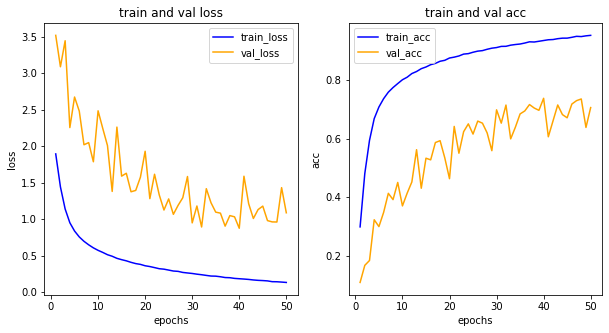

In [10]:
# loss/acc graph 그리기
import matplotlib.pyplot as plt

epochs = range(1, len(train_los)+1)
fig = plt.figure(figsize=(10,5))

# 첫번째 열
ax1 = fig.add_subplot(1,2,1) 
ax1.plot(epochs, train_los, color ='blue', label='train_loss')
ax1.plot(epochs, val_los, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')          
ax1.legend()

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_acces, color = 'blue', label = 'train_acc')
ax2.plot(epochs, valid_accses, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
PATH = './weights/'

torch.save(net, PATH + 'resnet18_model.pt')  # 전체 모델 저장
torch.save(net.state_dict(), PATH + 'resnet18_model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'resnet18_all.tar')

# Data Augmentation을 test에도 적용

In [11]:
# ResNet18 함수 정의
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2]) # 각각의 basic블록이 두번씩 중첩될 수 있게 만든다.

import numpy as np
import torch
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms

### augmentation 추가
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), #추가한 것
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #추가한 것
])

transform_test = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), #추가한 것
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #추가한 것
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
# 훈련 데이터
print(train_dataset.data.shape, len(train_dataset.targets))
#print(train_dataset.targets)

# 테스트 데이터
print(test_dataset.data.shape, len(test_dataset.targets))
#print(test_dataset.targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

print('CIFAR10 ready~')

(50000, 32, 32, 3) 50000
(10000, 32, 32, 3) 10000
CIFAR10 ready~


In [13]:
# CUDA setting
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

net = ResNet18()
net = net.to(DEVICE)

learning_rate = 0.001
file_name = 'resnet18_cifar10.pth'# 학습이 진행됨에 따라 이러한 이름으로 모델이 저장되도록 설정

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

# 손실 함수 로그
train_losses = []
train_acces = []
valid_losses = []
valid_accses = []


cuda


In [14]:
# 50회 반복
for epoch in range(50):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])

  # train
  net.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = net(X)

    # CrossEntropyLoss 계산
    loss = criterion(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  net.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = net(X)

      # CrossEntropyLoss 계산
      loss = criterion(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
     # for x in valid_losses:
      #  val_los.append(x.cpu().detach())
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  train_acces.append(np.mean(total_train_acc))
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

Epoch:001 - train loss: 1.9149 acc: 0.2911 - valid loss: 1.6929 acc: 0.3744
Epoch:002 - train loss: 1.4715 acc: 0.4676 - valid loss: 1.3469 acc: 0.5138
Epoch:003 - train loss: 1.1662 acc: 0.5850 - valid loss: 1.0682 acc: 0.6165
Epoch:004 - train loss: 0.9741 acc: 0.6572 - valid loss: 0.9465 acc: 0.6737
Epoch:005 - train loss: 0.8547 acc: 0.7009 - valid loss: 0.8418 acc: 0.7101
Epoch:006 - train loss: 0.7667 acc: 0.7321 - valid loss: 0.8513 acc: 0.7081
Epoch:007 - train loss: 0.7075 acc: 0.7547 - valid loss: 0.7476 acc: 0.7454
Epoch:008 - train loss: 0.6608 acc: 0.7722 - valid loss: 0.7088 acc: 0.7563
Epoch:009 - train loss: 0.6199 acc: 0.7864 - valid loss: 0.6777 acc: 0.7655
Epoch:010 - train loss: 0.5811 acc: 0.7978 - valid loss: 0.6600 acc: 0.7729
Epoch:011 - train loss: 0.5512 acc: 0.8094 - valid loss: 0.6080 acc: 0.7932
Epoch:012 - train loss: 0.5274 acc: 0.8177 - valid loss: 0.6281 acc: 0.7791
Epoch:013 - train loss: 0.4954 acc: 0.8292 - valid loss: 0.6230 acc: 0.7874
Epoch:014 - 

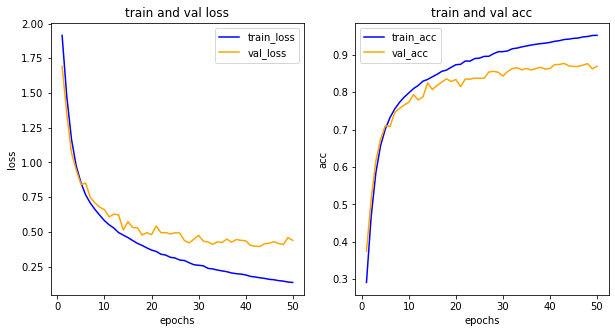

In [15]:
# loss/acc graph 그리기
import matplotlib.pyplot as plt

epochs = range(1, len(train_los)+1)
fig = plt.figure(figsize=(10,5))

# 첫번째 열
ax1 = fig.add_subplot(1,2,1) 
ax1.plot(epochs, train_los, color ='blue', label='train_loss')
ax1.plot(epochs, val_los, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')          
ax1.legend()

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_acces, color = 'blue', label = 'train_acc')
ax2.plot(epochs, valid_accses, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
PATH = './weights/'

torch.save(net, PATH + 'resnet18_model.pt')  # 전체 모델 저장
torch.save(net.state_dict(), PATH + 'resnet18_model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'resnet18_all.tar')